<a href="https://colab.research.google.com/github/HappyBearDay/Deep_Learning_Image_Multi_label/blob/master/image_project_sub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA20001 Deep Learning - Group Project
## Image project

**Due Thursday, December 13, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imread` from `matplotlib.pyplot`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
! pip install torch torchvision torchsummary sklearn

In [0]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

## Download the data

In [0]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile

In [0]:
train_path = 'train'
dl_file = 'dl2018-image-proj.zip'
dl_url = 'https://users.aalto.fi/mvsjober/misc/'

zip_path = os.path.join(train_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=train_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(train_path)
    #os.unlink(zip_path)

In [0]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU!


The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

In [0]:
import os
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random as rd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
img_path = "./train/images/"
labels_path = "./train/annotations/"

### Data preprocessing

In [0]:
images_path = "train/images/" 
image_files = [(images_path+f) for f in os.listdir(images_path) \
                if os.path.isfile(os.path.join(images_path, f))]
images = []
for current_img_path in image_files:
    current_img_vector =  plt.imread( current_img_path )
    filename_without_extension = os.path.basename(current_img_path)[:-4] # :-4 to drop the extension
    img_num = filename_without_extension[2:] # drop the heading "im"
    images += [img_num]
del image_files

In [0]:
data=images
labels = [[] for _ in range(len(data))] # Empty list of labels
annotations_path = "train/annotations/"
annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
        if os.path.isfile(os.path.join(annotations_path, f))]
for file in annotations_files:
    label = os.path.basename(file)[:-4] # :-4 to drop the extension
    with open(file) as f: # file is the name of the label currently read
        img_nums = f.read().split()
    for img_num in img_nums:
        if img_num not in data:
            continue
        labels[data.index(img_num)].append(label)

In [0]:
class OneHotTransformer:
    def __init__(self):
        annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
        self.vocabulary = []
        for file in annotations_files:
            label = os.path.basename(file)[:-4] # :-4 to drop the extension
            self.vocabulary.append(label)
    def toOneHot(self, labels):
        res = [0]*len(self.vocabulary)
        for i, voc in enumerate(self.vocabulary):
            if voc in labels:
                res[i] = 1
        return np.array(res)
    def toVocabulary(self, onehot):
        res = []
        for i, n in enumerate(onehot):
            if n: res.append(self.vocabulary[i])
        return res
oneHotTransformer = OneHotTransformer()

In [0]:
# Files to pytorch dataset
# Inspired from https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from PIL import Image

#merging_method : 
# 0 : Convert  a colored image to grey image
# 1 : Complete a grey    image with zeros   to a have colored image
# 2 : Complete a grey    image with himself to a have colored image


class imageDataset(Dataset):
    def __init__(self, data_basenames, merging_method = 2, channels = 3, height = 128, width = 128, transforms = transforms.ToTensor(), processing = False, trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])):
        """
        data_basenames is a list of id of image, such as ["9885", "9886"]
        transforms is a list of transformation. it last element should be transforms.ToTensor()
        """
        def parse_labels(data_paths):
            """ Parse to one hot """
            labels = [[] for _ in range(len(data_paths))] # Empty list of labels
            annotations_path = "train/annotations/"
            annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
            vocabulary = []
            for file in annotations_files:
                label = os.path.basename(file)[:-4] # :-4 to drop the extension
                vocabulary.append(label)
                with open(file) as f: # file is the name of the label currently read
                    img_nums = f.read().split()
                for img_num in img_nums:
                    if img_num not in data_paths:
                        continue
                    labels[data_paths.index(img_num)].append(label)
            return labels
          
        self.data = data_basenames
        self.labels = parse_labels(data_basenames)
        self.channels = channels
        self.height = height
        self.width = width
        self.transforms = transforms
        self.data_len = len(data_basenames)
        self.merging_method = merging_method
        self.trans = trans
        self.processing = processing

    def __getitem__(self, index):
        img_path = "train/images/im" + self.data[index] + ".jpg"
        data = Image.open(img_path)
        
        if self.processing:
             img = self.trans(data)
        
        elif self.transforms is not None:
            img = self.transforms(data)
        #labels = np.array(self.labels[index])
        #print(self.labels[index])
        
        if(self.merging_method == 0 ):
            
            if img.shape[0] == 3:
              img = img[0] + img[1] + img[2]
              img /= 3
              img = img.reshape((1, self.height, self.width))
              
        elif(self.merging_method == 1):
          
            if img.shape[0] == 1:  # change graysclae images to RGB
                zeros_torser = torch.zeros([1, self.height, self.width])
                img = torch.cat((img,zeros_torser, zeros_torser),0)
                
        elif(self.merging_method == 2):  
            if img.shape[0] == 1:  # change graysclae images to RGB
                img = torch.cat((img,img, img),0)
        
            
        labels = self.labels[index]
        one_hot_labels = oneHotTransformer.toOneHot(labels)
        return img, one_hot_labels

    def __len__(self):
        return self.data_len

    
import random
random.shuffle(images) # So we make sure test data has all kinds of label, in case
                                 # the repartition is not even according to label names


In [0]:
batch_size = 16

# 80% train, 20% test
index_cut =  int(len(images)*0.8)

train_dataset_0 = imageDataset(images[:index_cut], merging_method = 0)
train_loader_0 = torch.utils.data.DataLoader(dataset=train_dataset_0,
                                          batch_size=batch_size,
                                          shuffle=True)
test_dataset_0 = imageDataset(images[index_cut:], merging_method = 0)
test_loader_0 = torch.utils.data.DataLoader(dataset=test_dataset_0,
                                          batch_size=batch_size,
                                          shuffle=True)

train_dataset_1 = imageDataset(images[:index_cut], merging_method = 1)
train_loader_1 = torch.utils.data.DataLoader(dataset=train_dataset_1,
                                          batch_size=batch_size,
                                          shuffle=True)
test_dataset_1 = imageDataset(images[index_cut:], merging_method = 1)
test_loader_1 = torch.utils.data.DataLoader(dataset=test_dataset_1,
                                          batch_size=batch_size,
                                          shuffle=True)

train_dataset_2 = imageDataset(images[:index_cut], merging_method = 2)
train_loader_2 = torch.utils.data.DataLoader(dataset=train_dataset_2,
                                          batch_size=batch_size,
                                          shuffle=True)
test_dataset_2 = imageDataset(images[index_cut:], merging_method = 2)
test_loader_2 = torch.utils.data.DataLoader(dataset=test_dataset_2,
                                          batch_size=batch_size,
                                          shuffle=True)

train_dataset_3 = imageDataset(images[:index_cut], merging_method = 2, processing = True)
train_loader_3 = torch.utils.data.DataLoader(dataset=train_dataset_3,
                                          batch_size=batch_size,
                                          shuffle=True)
test_dataset_3 = imageDataset(images[index_cut:], merging_method = 2, processing = True)
test_loader_3 = torch.utils.data.DataLoader(dataset=test_dataset_3,
                                          batch_size=batch_size,
                                          shuffle=True)

In [0]:
data0, target0 = next(train_loader_0.__iter__()) # Iteration works!
data1, target1 = next(train_loader_1.__iter__())
data2, target2 = next(train_loader_2.__iter__())
data3, target3 = next(train_loader_3.__iter__())

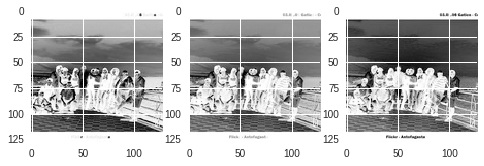

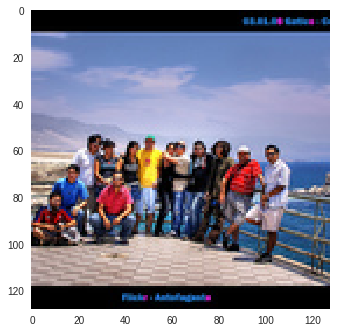

tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0])
labels: ['female', 'portrait', 'male', 'people']


In [0]:
# 3 channel show: merging method 2
data2, target2 = next(train_loader_2.__iter__()) # Iteration works!

d0 = data2[0]
t0 = target2[0]

f, axs = plt.subplots(1,3)
axs[0].imshow(d0[0])
axs[1].imshow(d0[1])
axs[2].imshow(d0[2])
plt.show()

arr_ = d0.transpose(0,-1)
arr_ = np.rot90(arr_, 3)
arr_ = np.flip(arr_, axis=1)
plt.imshow(arr_)
plt.grid(None)
plt.show()
print(t0)
print("labels:", oneHotTransformer.toVocabulary(t0))


### Define train, validate and evaluate functions

In [0]:
def train_net(model, train_loader, epoch, trainLoss, interval = 100):
    # set model to train
    model.train()
    loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device) # to GPU
        target = target.float().to(device) # to GPU, ".float()" is improtant, otherwise got error.
        
        # set zero gradient buffer
        optimizer.zero_grad()
        
        # compute the output and Loss
        output = model(data)
        Loss = criterion(output, target)
        
        # back prop
        Loss.backward()
        
        # update weights
        optimizer.step()
        
        # print information
        if batch_idx % interval == 0:
            print("Train Epoch: {} [{}/{} {:.0f}%]\tLoss: {:.6f}".format(epoch, len(data)*batch_idx, len(train_loader)*len(data), batch_idx/len(train_loader)*100, Loss.data.item()))   
       
        loss += Loss
    loss/=len(train_loader)
    trainLoss.append(loss)

def validate(model, test_loader, lossv, verbose=True):
  loss, acc, prec, rec = 0,0,0,0
  for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
   
    loss += criterion(output, targetv.data.to(device).float()).data.item()
  
  loss /= len(test_loader)
  
  lossv.append(loss)
  
  if verbose:
    print('Validation set: Average loss: {:.4f}\n'.format(
            loss))

In [0]:
def evaluate(model, test_loader, treshold, lossv, accv, precv, recv, verbose=True):
  loss, acc, prec, rec = 0,0,0,0
  for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
    
    pred = torch.sigmoid(output).data.gt(treshold) # Activated output
    
    loss += criterion(output, targetv.data.to(device).float()).data.item()
    # confusion matrix (true/false negative/positive)
    tp = (pred + targetv.data.to(device).byte()).eq(2).sum()
    fp = (pred - targetv.data.to(device).byte()).eq(1).sum()
    fn = (pred - targetv.data.to(device).byte()).eq(-1).sum()
    tn = (pred + targetv.data.to(device).byte()).eq(0).sum()
    acc += (tp + tn).float() / (tp + tn + fp + fn)

    if tp+fp!=0:
      prec += tp.float() / (tp + fp)
    else:
      prec += 0.0
    if tp+fn != 0:
      rec += tp.float() / (tp + fn)
    else:
      rec += 0.0
  loss /= len(test_loader)
  acc /= len(test_loader)
  prec /= len(test_loader)
  rec /= len(test_loader)
  lossv.append(loss)
  accv.append(acc)
  precv.append(prec)
  recv.append(rec)
  if verbose:
    print('Validation set: Average loss: {:.4f}, Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%'.format(
            loss, acc*100, prec*100, rec*100))
    print("\t\tF1 score : {:.2f}%\n".format(100*2*(prec*rec)/(prec+rec)))

### Models

#### a) Simple CNN models

In [0]:
class simple_cnn2_drop(nn.Module):
    def __init__(self, nclass = 14):
        super(simple_cnn2_drop,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = 11,padding = 0,stride = 4),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size = 5,padding = 0,stride = 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2*2*128, 128)
        self.fc2 = nn.Linear(128, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.dropout(out)
        out = out.view(out.size(0),-1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]          23,296
       BatchNorm2d-2           [-1, 64, 30, 30]             128
              ReLU-3           [-1, 64, 30, 30]               0
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5            [-1, 128, 5, 5]         204,928
       BatchNorm2d-6            [-1, 128, 5, 5]             256
              ReLU-7            [-1, 128, 5, 5]               0
         MaxPool2d-8            [-1, 128, 2, 2]               0
           Dropout-9            [-1, 128, 2, 2]               0
           Linear-10                  [-1, 128]          65,664
           Linear-11                   [-1, 14]           1,806
Total params: 296,078
Trainable params: 296,078
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/

In [0]:
model = simple_cnn2_drop().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 

In [0]:
class simple_cnn3(nn.Module):
    def __init__(self, nclass = 14):
        super(simple_cnn3,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size = 11,padding = 0,stride = 4),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size = 5,padding = 0,stride = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2*2*32, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.dropout(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        return out
      
model = simple_cnn3().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]           5,824
       BatchNorm2d-2           [-1, 16, 30, 30]              32
              ReLU-3           [-1, 16, 30, 30]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5             [-1, 32, 5, 5]          12,832
       BatchNorm2d-6             [-1, 32, 5, 5]              64
              ReLU-7             [-1, 32, 5, 5]               0
         MaxPool2d-8             [-1, 32, 2, 2]               0
           Dropout-9             [-1, 32, 2, 2]               0
           Linear-10                   [-1, 14]           1,806
Total params: 20,558
Trainable params: 20,558
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.37
Params size (MB): 0.08
Estimated Tot

In [0]:
model = simple_cnn3().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 

#### b) Deep CNN

In [0]:
class deep_cnn(nn.Module):
    def __init__(self, input_channels=3):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(10, stride=3)
        )
        #self.fc1 = nn.Linear(4096, 20)
        self.lastlayer = nn.Sequential(
   #         nn.Dropout(p=0.5),
            nn.Linear(4096//64, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        #out = self.conv4(out)
        out = out.view(out.size(0),-1)
        out = self.lastlayer(out)
        return out
      
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 124, 124]           1,216
       BatchNorm2d-2         [-1, 16, 124, 124]              32
              ReLU-3         [-1, 16, 124, 124]               0
         MaxPool2d-4           [-1, 16, 40, 40]               0
            Conv2d-5           [-1, 32, 36, 36]          12,832
       BatchNorm2d-6           [-1, 32, 36, 36]              64
              ReLU-7           [-1, 32, 36, 36]               0
         MaxPool2d-8           [-1, 32, 11, 11]               0
            Conv2d-9             [-1, 64, 7, 7]          51,264
      BatchNorm2d-10             [-1, 64, 7, 7]             128
             ReLU-11             [-1, 64, 7, 7]               0
        MaxPool2d-12             [-1, 64, 1, 1]               0
           Linear-13                   [-1, 14]             910
Total params: 66,446
Trainable params: 

In [0]:
model = deep_cnn().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss()

### Analysis with different data processing methods (train on deep_cnn)

#### a) Merge 1

In [0]:
%%time
model = deep_cnn().to(device)
epoch = 30

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
for i in range(1,1+epoch):
    train_net(model, train_loader_0,i, train_loss)
    validate(model, test_loader_0, val_loss)
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Image_project/Analysis_input/model_deepcnn0_epoch'+str(i)+'.pkl')



Train Epoch: 1 [0/16000 0%]	Loss: 0.743971
Train Epoch: 1 [1600/16000 10%]	Loss: 0.553688
Train Epoch: 1 [3200/16000 20%]	Loss: 0.436291
Train Epoch: 1 [4800/16000 30%]	Loss: 0.334922
Train Epoch: 1 [6400/16000 40%]	Loss: 0.271802
Train Epoch: 1 [8000/16000 50%]	Loss: 0.255924
Train Epoch: 1 [9600/16000 60%]	Loss: 0.229531
Train Epoch: 1 [11200/16000 70%]	Loss: 0.167977
Train Epoch: 1 [12800/16000 80%]	Loss: 0.251539
Train Epoch: 1 [14400/16000 90%]	Loss: 0.232335
Validation set: Average loss: 0.2162

Train Epoch: 2 [0/16000 0%]	Loss: 0.197368
Train Epoch: 2 [1600/16000 10%]	Loss: 0.184391
Train Epoch: 2 [3200/16000 20%]	Loss: 0.205732
Train Epoch: 2 [4800/16000 30%]	Loss: 0.194156
Train Epoch: 2 [6400/16000 40%]	Loss: 0.280689
Train Epoch: 2 [8000/16000 50%]	Loss: 0.201463
Train Epoch: 2 [9600/16000 60%]	Loss: 0.195850
Train Epoch: 2 [11200/16000 70%]	Loss: 0.151470
Train Epoch: 2 [12800/16000 80%]	Loss: 0.155236
Train Epoch: 2 [14400/16000 90%]	Loss: 0.162306
Validation set: Average 

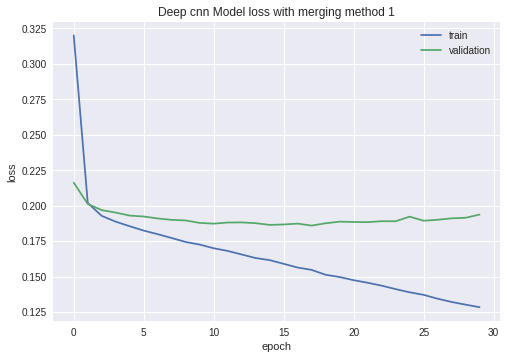

In [0]:
loss_0t = train_loss
loss_0v = val_loss

plt.title("Deep cnn Model loss with merging method 1")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

#### b) Merge 2

In [0]:
%%time
model = deep_cnn(input_channels = 3).to(device)
epoch = 30

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
for i in range(1,1+epoch):
    train_net(model, train_loader_1,i, train_loss)
    validate(model, test_loader_1, val_loss)
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Image_project/Analysis_input/model_deepcnn1_epoch'+str(i)+'.pkl')



Train Epoch: 1 [0/16000 0%]	Loss: 0.731542
Train Epoch: 1 [1600/16000 10%]	Loss: 0.507179
Train Epoch: 1 [3200/16000 20%]	Loss: 0.382588
Train Epoch: 1 [4800/16000 30%]	Loss: 0.378191
Train Epoch: 1 [6400/16000 40%]	Loss: 0.298161
Train Epoch: 1 [8000/16000 50%]	Loss: 0.286079
Train Epoch: 1 [9600/16000 60%]	Loss: 0.238348
Train Epoch: 1 [11200/16000 70%]	Loss: 0.267318
Train Epoch: 1 [12800/16000 80%]	Loss: 0.265799
Train Epoch: 1 [14400/16000 90%]	Loss: 0.197233
Validation set: Average loss: 0.2139

Train Epoch: 2 [0/16000 0%]	Loss: 0.207101
Train Epoch: 2 [1600/16000 10%]	Loss: 0.233740
Train Epoch: 2 [3200/16000 20%]	Loss: 0.211937
Train Epoch: 2 [4800/16000 30%]	Loss: 0.194322
Train Epoch: 2 [6400/16000 40%]	Loss: 0.176323
Train Epoch: 2 [8000/16000 50%]	Loss: 0.210766
Train Epoch: 2 [9600/16000 60%]	Loss: 0.173454
Train Epoch: 2 [11200/16000 70%]	Loss: 0.177653
Train Epoch: 2 [12800/16000 80%]	Loss: 0.189558
Train Epoch: 2 [14400/16000 90%]	Loss: 0.176248
Validation set: Average 

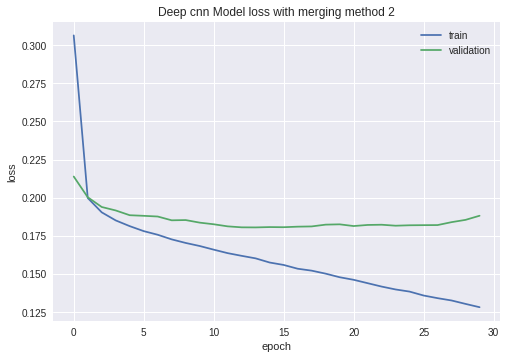

In [0]:
loss_1t = train_loss
loss_1v = val_loss

plt.title("Deep cnn Model loss with merging method 2")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

#### c) Merge 3

In [0]:
%%time
model = deep_cnn(input_channels = 3).to(device)
epoch = 30

learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()

train_loss, val_loss = [], []
for i in range(1,1+epoch):
    train_net(model, train_loader_2, i, train_loss)
    validate(model, test_loader_2, val_loss)
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Image_project/Analysis_input/model_deepcnn2_epoch'+str(i)+'.pkl')
       

Train Epoch: 1 [0/16000 0%]	Loss: 0.713531
Train Epoch: 1 [1600/16000 10%]	Loss: 0.494121
Train Epoch: 1 [3200/16000 20%]	Loss: 0.370372
Train Epoch: 1 [4800/16000 30%]	Loss: 0.307712
Train Epoch: 1 [6400/16000 40%]	Loss: 0.302980
Train Epoch: 1 [8000/16000 50%]	Loss: 0.227260
Train Epoch: 1 [9600/16000 60%]	Loss: 0.224446
Train Epoch: 1 [11200/16000 70%]	Loss: 0.211022
Train Epoch: 1 [12800/16000 80%]	Loss: 0.238047
Train Epoch: 1 [14400/16000 90%]	Loss: 0.180748
Validation set: Average loss: 0.2133

Train Epoch: 2 [0/16000 0%]	Loss: 0.209862
Train Epoch: 2 [1600/16000 10%]	Loss: 0.180508
Train Epoch: 2 [3200/16000 20%]	Loss: 0.188290
Train Epoch: 2 [4800/16000 30%]	Loss: 0.178145
Train Epoch: 2 [6400/16000 40%]	Loss: 0.170748
Train Epoch: 2 [8000/16000 50%]	Loss: 0.224548
Train Epoch: 2 [9600/16000 60%]	Loss: 0.176124
Train Epoch: 2 [11200/16000 70%]	Loss: 0.257514
Train Epoch: 2 [12800/16000 80%]	Loss: 0.172005
Train Epoch: 2 [14400/16000 90%]	Loss: 0.099723
Validation set: Average 

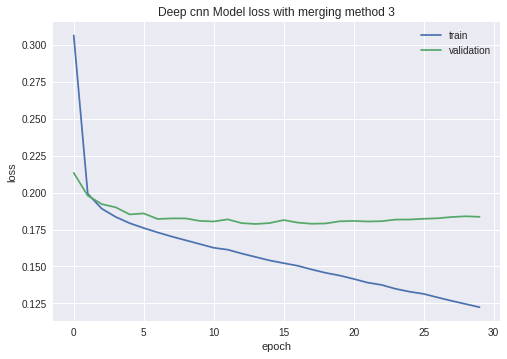

In [0]:
loss_2t = train_loss
loss_2v = val_loss 

plt.title("Deep cnn Model loss with merging method 3")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

#### d) Merge 3 with resizing

In [0]:
class deep_cnns(nn.Module): # due to different input size, the deep_cnn has different output size of last convolutional layer.
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(10, stride=3)
        )
        #self.fc1 = nn.Linear(4096, 20)
        self.lastlayer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(5*5*64, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        #out = self.conv4(out)
        out = out.view(out.size(0),-1)
        out = self.lastlayer(out)
        return out

In [0]:
%%time
model = deep_cnns().to(device)
epoch = 30

learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()

train_loss, val_loss = [], []
for i in range(1,1+epoch):
    train_net(model, train_loader_3, i, train_loss)
    validate(model, test_loader_3, val_loss)
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Image_project/Analysis_input/model_deepcnn3_epoch'+str(i)+'.pkl')
    
loss_3t = train_loss
loss_3v = val_loss    

Train Epoch: 1 [0/16000 0%]	Loss: 0.744592
Train Epoch: 1 [1600/16000 10%]	Loss: 0.213710
Train Epoch: 1 [3200/16000 20%]	Loss: 0.209129
Train Epoch: 1 [4800/16000 30%]	Loss: 0.256412
Train Epoch: 1 [6400/16000 40%]	Loss: 0.217852
Train Epoch: 1 [8000/16000 50%]	Loss: 0.214230
Train Epoch: 1 [9600/16000 60%]	Loss: 0.111161
Train Epoch: 1 [11200/16000 70%]	Loss: 0.222380
Train Epoch: 1 [12800/16000 80%]	Loss: 0.219125
Train Epoch: 1 [14400/16000 90%]	Loss: 0.177939
Validation set: Average loss: 0.1980

Train Epoch: 2 [0/16000 0%]	Loss: 0.228655
Train Epoch: 2 [1600/16000 10%]	Loss: 0.168308
Train Epoch: 2 [3200/16000 20%]	Loss: 0.135486
Train Epoch: 2 [4800/16000 30%]	Loss: 0.202290
Train Epoch: 2 [6400/16000 40%]	Loss: 0.256676
Train Epoch: 2 [8000/16000 50%]	Loss: 0.211389
Train Epoch: 2 [9600/16000 60%]	Loss: 0.226139
Train Epoch: 2 [11200/16000 70%]	Loss: 0.300766
Train Epoch: 2 [12800/16000 80%]	Loss: 0.205644
Train Epoch: 2 [14400/16000 90%]	Loss: 0.233230
Validation set: Average 

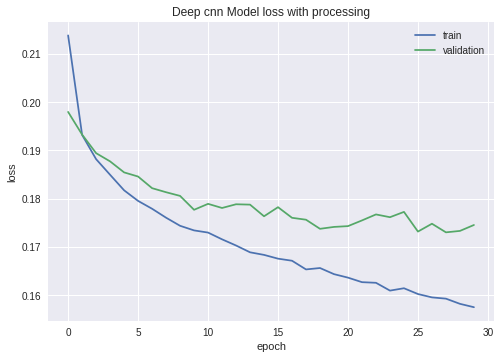

In [0]:
plt.title("Deep cnn Model loss with processing")
plt.plot(loss_3t, label="train")
plt.plot(loss_3v, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

#### Evaluation and Analysis 

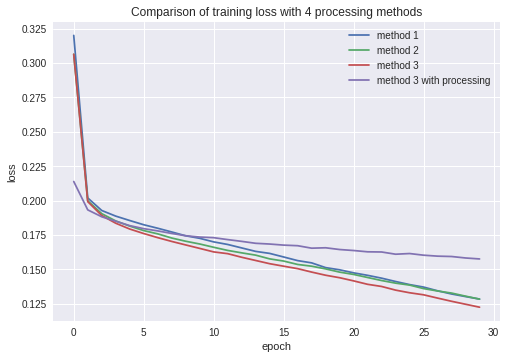

In [0]:
plt.title("Comparison of training loss with 4 processing methods")
plt.plot(loss_0t, label="method 1")
plt.plot(loss_1t, label="method 2")
plt.plot(loss_2t, label="method 3")
plt.plot(loss_3t, label="method 3 with processing")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

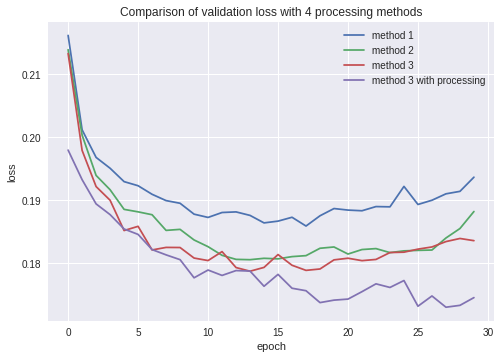

In [0]:
plt.title("Comparison of validation loss with 4 processing methods")
plt.plot(loss_0v, label="method 1")
plt.plot(loss_1v, label="method 2")
plt.plot(loss_2v, label="method 3")
plt.plot(loss_3v, label="method 3 with processing")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

As we can see, the validation loss of the model with merge type 3 and resizing is lowest. And merge 2 and merge 3 seems to have similar results.

In [0]:
treshold = 0.2
model0 = deep_cnn().to(device)
model0.load_state_dict(torch.load('/content/gdrive/My Drive/Image_project/Analysis_input/model_deepcnn0_epoch10.pkl'))
lossv0, accv0, precv0, recv0 = [], [], [], []
evaluate(model0, test_loader_0, treshold, lossv0, accv0, precv0, recv0, verbose=True)

model1 = deep_cnn(input_channels = 3).to(device)
model1.load_state_dict(torch.load('/content/gdrive/My Drive/Image_project/Analysis_input/model_deepcnn1_epoch13.pkl'))
lossv1, accv1, precv1, recv1 = [], [], [], []
evaluate(model1, test_loader_1, treshold, lossv1, accv1, precv1, recv1, verbose=True)

model2 = deep_cnn(input_channels = 3).to(device)
model2.load_state_dict(torch.load('/content/gdrive/My Drive/Image_project/Analysis_input/model_deepcnn2_epoch11.pkl'))
lossv2, accv2, precv2, recv2 = [], [], [], []
evaluate(model2, test_loader_2, treshold, lossv2, accv2, precv2, recv2, verbose=True)

model3 = deep_cnns().to(device)
model3.load_state_dict(torch.load('/content/gdrive/My Drive/Image_project/Analysis_input/model_deepcnn3_epoch30.pkl'))
lossv3, accv3, precv3, recv3 = [], [], [], []
evaluate(model3, test_loader_3, treshold, lossv3, accv3, precv3, recv3, verbose=True)

Validation set: Average loss: 0.1733, Accuracy: 90.63%, Precision: 39.96%, Recall: 59.39%
		F1 score : 47.78%

Validation set: Average loss: 0.1630, Accuracy: 90.79%, Precision: 41.18%, Recall: 64.64%
		F1 score : 50.31%

Validation set: Average loss: 0.1648, Accuracy: 91.36%, Precision: 43.39%, Recall: 61.29%
		F1 score : 50.81%

Validation set: Average loss: 0.1739, Accuracy: 89.88%, Precision: 38.24%, Recall: 62.62%
		F1 score : 47.48%



In [0]:
treshold = 0.3
model0 = deep_cnn().to(device)
model0.load_state_dict(torch.load('/content/gdrive/My Drive/Image_project/Analysis_input/model_deepcnn0_epoch10.pkl'))
lossv0, accv0, precv0, recv0 = [], [], [], []
evaluate(model0, test_loader_0, treshold, lossv0, accv0, precv0, recv0, verbose=True)

model1 = deep_cnn(input_channels = 3).to(device)
model1.load_state_dict(torch.load('/content/gdrive/My Drive/Image_project/Analysis_input/model_deepcnn1_epoch13.pkl'))
lossv1, accv1, precv1, recv1 = [], [], [], []
evaluate(model1, test_loader_1, treshold, lossv1, accv1, precv1, recv1, verbose=True)

model2 = deep_cnn(input_channels = 3).to(device)
model2.load_state_dict(torch.load('/content/gdrive/My Drive/Image_project/Analysis_input/model_deepcnn2_epoch11.pkl'))
lossv2, accv2, precv2, recv2 = [], [], [], []
evaluate(model2, test_loader_2, treshold, lossv2, accv2, precv2, recv2, verbose=True)

model3 = deep_cnns().to(device)
model3.load_state_dict(torch.load('/content/gdrive/My Drive/Image_project/Analysis_input/model_deepcnn3_epoch30.pkl'))
lossv3, accv3, precv3, recv3 = [], [], [], []
evaluate(model3, test_loader_3, treshold, lossv3, accv3, precv3, recv3, verbose=True)

Validation set: Average loss: 0.1735, Accuracy: 92.86%, Precision: 50.56%, Recall: 40.92%
		F1 score : 45.23%

Validation set: Average loss: 0.1625, Accuracy: 92.89%, Precision: 50.49%, Recall: 50.71%
		F1 score : 50.60%

Validation set: Average loss: 0.1648, Accuracy: 93.18%, Precision: 53.38%, Recall: 45.63%
		F1 score : 49.20%

Validation set: Average loss: 0.1746, Accuracy: 92.01%, Precision: 44.69%, Recall: 48.27%
		F1 score : 46.41%



According to the above results, we can see that the merge 2 and merge 3 yield higher F1 score and accuracy compared to other two methods. And we decided to use merge 3 as our final processing method. 

### Training

#### a) sim_cnn2_drop

In [0]:
%%time
model = simple_cnn2_drop().to(device)
epoch = 30

learning_rate = 0.00001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()

train_loss, val_loss = [], []
for i in range(1,1+epoch):
    train_net(model, train_loader_2, i, train_loss)
    validate(model, test_loader_2, val_loss)
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Image_project/Our_models/model_simcnn2_drop_epoch'+str(i)+'.pkl')

Train Epoch: 1 [0/16000 0%]	Loss: 0.728135
Train Epoch: 1 [1600/16000 10%]	Loss: 0.654320
Train Epoch: 1 [3200/16000 20%]	Loss: 0.582733
Train Epoch: 1 [4800/16000 30%]	Loss: 0.498478
Train Epoch: 1 [6400/16000 40%]	Loss: 0.436689
Train Epoch: 1 [8000/16000 50%]	Loss: 0.378461
Train Epoch: 1 [9600/16000 60%]	Loss: 0.361731
Train Epoch: 1 [11200/16000 70%]	Loss: 0.334634
Train Epoch: 1 [12800/16000 80%]	Loss: 0.276203
Train Epoch: 1 [14400/16000 90%]	Loss: 0.241955
Validation set: Average loss: 0.2450

Train Epoch: 2 [0/16000 0%]	Loss: 0.222451
Train Epoch: 2 [1600/16000 10%]	Loss: 0.190972
Train Epoch: 2 [3200/16000 20%]	Loss: 0.248983
Train Epoch: 2 [4800/16000 30%]	Loss: 0.246174
Train Epoch: 2 [6400/16000 40%]	Loss: 0.200301
Train Epoch: 2 [8000/16000 50%]	Loss: 0.177618
Train Epoch: 2 [9600/16000 60%]	Loss: 0.243063
Train Epoch: 2 [11200/16000 70%]	Loss: 0.256995
Train Epoch: 2 [12800/16000 80%]	Loss: 0.244287
Train Epoch: 2 [14400/16000 90%]	Loss: 0.196725
Validation set: Average 

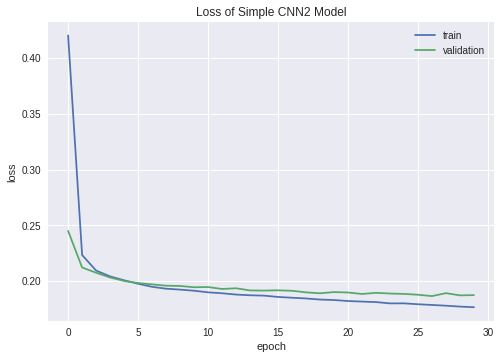

In [0]:
loss_sim2t = train_loss
loss_sim2v = val_loss 

plt.title("Loss of Simple CNN2 Model")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

#### b) simple_cnn_3

In [0]:
%%time
model = simple_cnn3().to(device)
epoch = 30

learning_rate = 0.00001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()

train_loss, val_loss = [], []
for i in range(1,1+epoch):
    train_net(model, train_loader_2, i, train_loss)
    validate(model, test_loader_2, val_loss)
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Image_project/Our_models/model_simcnn3_epoch'+str(i)+'.pkl')

Train Epoch: 1 [0/16000 0%]	Loss: 0.716171
Train Epoch: 1 [1600/16000 10%]	Loss: 0.706740
Train Epoch: 1 [3200/16000 20%]	Loss: 0.671897
Train Epoch: 1 [4800/16000 30%]	Loss: 0.640201
Train Epoch: 1 [6400/16000 40%]	Loss: 0.607562
Train Epoch: 1 [8000/16000 50%]	Loss: 0.603095
Train Epoch: 1 [9600/16000 60%]	Loss: 0.565395
Train Epoch: 1 [11200/16000 70%]	Loss: 0.556616
Train Epoch: 1 [12800/16000 80%]	Loss: 0.543989
Train Epoch: 1 [14400/16000 90%]	Loss: 0.508607
Validation set: Average loss: 0.4851

Train Epoch: 2 [0/16000 0%]	Loss: 0.474152
Train Epoch: 2 [1600/16000 10%]	Loss: 0.453058
Train Epoch: 2 [3200/16000 20%]	Loss: 0.451841
Train Epoch: 2 [4800/16000 30%]	Loss: 0.447757
Train Epoch: 2 [6400/16000 40%]	Loss: 0.411141
Train Epoch: 2 [8000/16000 50%]	Loss: 0.398608
Train Epoch: 2 [9600/16000 60%]	Loss: 0.389852
Train Epoch: 2 [11200/16000 70%]	Loss: 0.381994
Train Epoch: 2 [12800/16000 80%]	Loss: 0.340822
Train Epoch: 2 [14400/16000 90%]	Loss: 0.407034
Validation set: Average 

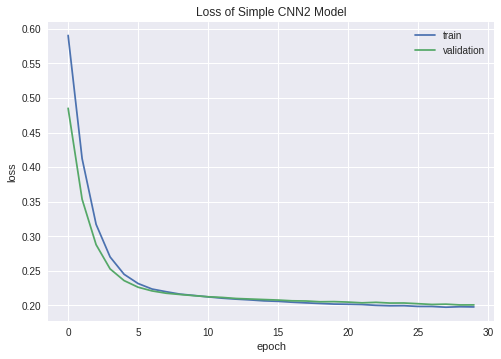

In [0]:
loss_sim3t = train_loss
loss_sim3v = val_loss 

plt.title("Loss of Simple CNN2 Model")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

#### c) deep_cnn

In [0]:
%%time
model = deep_cnn(input_channels = 3).to(device)
epoch = 30

learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()

train_loss, val_loss = [], []
for i in range(1,1+epoch):
    train_net(model, train_loader_2, i, train_loss)
    validate(model, test_loader_2, val_loss)
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Image_project/Our_models/model_deepcnn_epoch'+str(i)+'.pkl')

Train Epoch: 1 [0/16000 0%]	Loss: 0.778625
Train Epoch: 1 [1600/16000 10%]	Loss: 0.545743
Train Epoch: 1 [3200/16000 20%]	Loss: 0.401835
Train Epoch: 1 [4800/16000 30%]	Loss: 0.328048
Train Epoch: 1 [6400/16000 40%]	Loss: 0.311393
Train Epoch: 1 [8000/16000 50%]	Loss: 0.264173
Train Epoch: 1 [9600/16000 60%]	Loss: 0.222792
Train Epoch: 1 [11200/16000 70%]	Loss: 0.218435
Train Epoch: 1 [12800/16000 80%]	Loss: 0.191852
Train Epoch: 1 [14400/16000 90%]	Loss: 0.199943
Validation set: Average loss: 0.2100

Train Epoch: 2 [0/16000 0%]	Loss: 0.136997
Train Epoch: 2 [1600/16000 10%]	Loss: 0.167038
Train Epoch: 2 [3200/16000 20%]	Loss: 0.243562
Train Epoch: 2 [4800/16000 30%]	Loss: 0.154369
Train Epoch: 2 [6400/16000 40%]	Loss: 0.186535
Train Epoch: 2 [8000/16000 50%]	Loss: 0.159996
Train Epoch: 2 [9600/16000 60%]	Loss: 0.183481
Train Epoch: 2 [11200/16000 70%]	Loss: 0.182117
Train Epoch: 2 [12800/16000 80%]	Loss: 0.221194
Train Epoch: 2 [14400/16000 90%]	Loss: 0.189087
Validation set: Average 

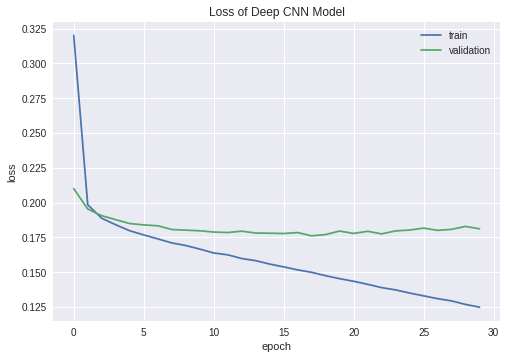

In [0]:
loss_deept = train_loss
loss_deepv = val_loss 

plt.title("Loss of Deep CNN Model")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

#### Evaluation and Analysis

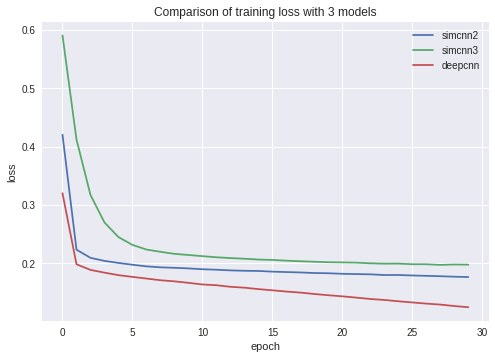

In [0]:
plt.title("Comparison of training loss with 3 models")
plt.plot(loss_sim2t, label="simcnn2")
plt.plot(loss_sim3t, label="simcnn3")
plt.plot(loss_deept, label="deepcnn")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

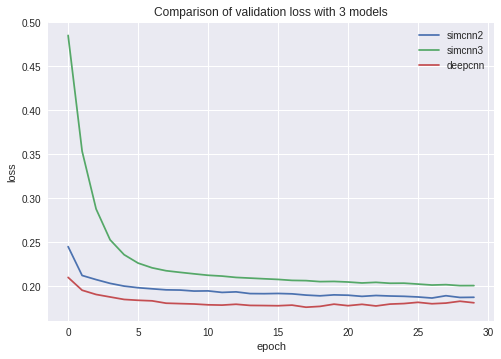

In [0]:
plt.title("Comparison of validation loss with 3 models")
plt.plot(loss_sim2v, label="simcnn2")
plt.plot(loss_sim3v, label="simcnn3")
plt.plot(loss_deepv, label="deepcnn")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [0]:
treshold = 0.2
model_sim2 = simple_cnn2_drop().to(device)
model_sim2.load_state_dict(torch.load('/content/gdrive/My Drive/Image_project/Our_models/model_simcnn2_drop_epoch30.pkl'))
lossv_sim2, accv_sim2, precv_sim2, recv_sim2 = [], [], [], []
evaluate(model_sim2, test_loader_2, treshold, lossv_sim2, accv_sim2, precv_sim2, recv_sim2, verbose=True)

model_sim3 = simple_cnn3().to(device)
model_sim3.load_state_dict(torch.load('/content/gdrive/My Drive/Image_project/Our_models/model_simcnn3_epoch30.pkl'))
lossv_sim3, accv_sim3, precv_sim3, recv_sim3 = [], [], [], []
evaluate(model_sim3, test_loader_2, treshold, lossv_sim3, accv_sim3, precv_sim3, recv_sim3, verbose=True)


model_deep = deep_cnn(input_channels = 3).to(device)
model_deep.load_state_dict(torch.load('/content/gdrive/My Drive/Image_project/Our_models/model_deepcnn_epoch15.pkl'))
lossv_deep, accv_deep, precv_deep, recv_deep = [], [], [], []
evaluate(model_deep, test_loader_2, treshold, lossv_deep, accv_deep, precv_deep, recv_deep, verbose=True)

Validation set: Average loss: 0.1869, Accuracy: 89.40%, Precision: 35.58%, Recall: 56.92%
		F1 score : 43.79%

Validation set: Average loss: 0.2000, Accuracy: 88.61%, Precision: 32.16%, Recall: 50.32%
		F1 score : 39.24%

Validation set: Average loss: 0.1783, Accuracy: 90.01%, Precision: 37.85%, Recall: 57.75%
		F1 score : 45.73%



In [0]:
treshold = 0.3
model_sim2 = simple_cnn2_drop().to(device)
model_sim2.load_state_dict(torch.load('/content/gdrive/My Drive/Image_project/Our_models/model_simcnn2_drop_epoch30.pkl'))
lossv_sim2, accv_sim2, precv_sim2, recv_sim2 = [], [], [], []
evaluate(model_sim2, test_loader_2, treshold, lossv_sim2, accv_sim2, precv_sim2, recv_sim2, verbose=True)

model_sim3 = simple_cnn3().to(device)
model_sim3.load_state_dict(torch.load('/content/gdrive/My Drive/Image_project/Our_models/model_simcnn3_epoch30.pkl'))
lossv_sim3, accv_sim3, precv_sim3, recv_sim3 = [], [], [], []
evaluate(model_sim3, test_loader_2, treshold, lossv_sim3, accv_sim3, precv_sim3, recv_sim3, verbose=True)


model_deep = deep_cnn(input_channels = 3).to(device)
model_deep.load_state_dict(torch.load('/content/gdrive/My Drive/Image_project/Our_models/model_deepcnn_epoch15.pkl'))
lossv_deep, accv_deep, precv_deep, recv_deep = [], [], [], []
evaluate(model_deep, test_loader_2, treshold, lossv_deep, accv_deep, precv_deep, recv_deep, verbose=True)

Validation set: Average loss: 0.1865, Accuracy: 91.76%, Precision: 42.87%, Recall: 40.93%
		F1 score : 41.88%

Validation set: Average loss: 0.2005, Accuracy: 91.49%, Precision: 39.43%, Recall: 31.98%
		F1 score : 35.31%

Validation set: Average loss: 0.1784, Accuracy: 92.19%, Precision: 45.77%, Recall: 41.60%
		F1 score : 43.58%



As we can see from both loss plots and the validation results, the deep_cnn is better than other two CNN structures.

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [0]:
torch.save(model.state_dict(), 'model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".  [See more here on how to load the model back](https://github.com/pytorch/pytorch/blob/761d6799beb3afa03657a71776412a2171ee7533/docs/source/notes/serialization.rst) if you want to continue training later.

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

In [0]:
to_test_path = 'to_test'
dl_file = 'dl2018-image-test.zip'
dl_url = 'https://users.aalto.fi/~mvsjober/misc/'

zip_path = os.path.join(to_test_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=to_test_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(to_test_path)

## Predict for test set

You should return your predictions for the test set in a plain text file.  The text file contains one row for each test set image.  Each row contains a binary prediction for each label (separated by a single space), 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
The order of the rows should be according to the numeric order of the image numbers.  In the test set, this means that the first row refers to image `im20001.jpg`, the second to `im20002.jpg`, and so on.

If you have the prediction output matrix prepared in `y` you can use the following function to save it to a text file.

In [0]:
order = ['baby', # given order, most likely different from the order constructed
 'bird',         # automatically in the preprocessing part.
 'car',
 'clouds',
 'dog',
 'female',
 'flower',
 'male',
 'night',
 'people',
 'portrait',
 'river',
 'sea',
 'tree']
# Permutation table (arrays' indices to permute) 
switch = [0 for _ in range(14)]
for i in range(14):
  searched =  order[i]
  switch[i] = oneHotTransformer.vocabulary.index(searched)

def batch_output_in_right_order(batch_pred, order_switch):
  return batch_pred[:, order_switch]
  

# Example for one batch
inputv, targetv = next(test_loader.__iter__())
inputv = inputv.to(device)
best_tresholds_as_tensor = torch.Tensor([0.2]*14).to(device)
batch_pred = torch.sigmoid(model(inputv).to(device)) > best_tresholds_as_tensor

batch_right_order = batch_output_in_right_order(batch_pred, switch)


Truth:  tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0])
Labelled Truth:  ['female', 'portrait', 'people']
----------
new order ['baby', 'bird', 'car', 'clouds', 'dog', 'female', 'flower', 'male', 'night', 'people', 'portrait', 'river', 'sea', 'tree']
re ordered tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0])


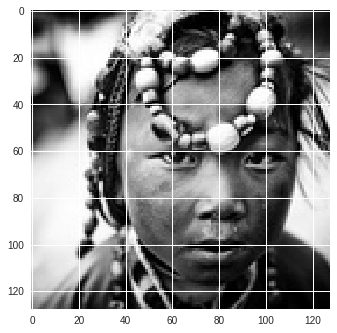

In [0]:
# Double check it works
print("Truth: ", targetv[0])
print("Labelled Truth: ", oneHotTransformer.toVocabulary(targetv[0]))

ex0 = batch_right_order[0]


print("-"*10)
print("new order", order)
#print(inputv.cpu().numpy()[0][0])


targetv_good_order = batch_output_in_right_order(targetv, switch)
t0 = targetv_good_order[0]
plt.imshow(inputv.cpu().numpy()[0][0], cmap="gray")
#print(batch_output_in_right_order(batch_pred, switch))
print("re ordered", t0)
plt.show()



In [0]:
images_path_test = "to_test/images/" 
image_files_test = [(images_path_test+f) for f in os.listdir(images_path_test) \
                if os.path.isfile(os.path.join(images_path_test, f))]

image_files_test = sorted(image_files_test)
def to_basename(rel_path):
  """ 'to_test/images/im20001.jpg' to '20001' """
  return rel_path[17:-4] # stripping 17 first chars and last 4 ones (extension of the file)
basenames_test = [to_basename(path) for path in image_files_test]
print(basenames_test[:10])

# load dataset
# TODO Need color and grayscale handling 

['20001', '20002', '20003', '20004', '20005', '20006', '20007', '20008', '20009', '20010']


In [0]:
inputv, targetv = next(test_loader.__iter__())
inputv = inputv.to(device)
model(inputv)
tresholds = treshold_opt.get_best_tresholds()
tresholds_as_tensor = torch.Tensor(tresholds).to(device)
batch_pred = torch.sigmoid(model(inputv).to(device)) > best_tresholds_as_tensor
print(batch_pred)

tensor([[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]], device='cuda:0',
       dtype=torch.uint8)


In [0]:
def batchprediction_to_txt(pred):
  listpred = pred.data.tolist()
  res = ""
  for labels in listpred:
    stringified_labels = map(str, labels)
    res += " ".join(stringified_labels) + "\n"
  return res


batch_right_order = batch_output_in_right_order(batch_pred, switch)
print(batchprediction_to_txt(batch_right_order))
# TODO : iterate over dataset and write labels batch by batch with the above function

0 0 0 0 0 1 0 1 0 1 1 0 0 0
0 0 0 0 0 1 0 1 0 1 1 0 0 0
0 0 0 0 0 1 0 1 0 1 1 0 0 0
0 0 0 0 0 0 0 1 0 0 0 0 0 0
0 0 0 0 0 1 0 1 0 1 1 0 0 0
0 0 0 0 0 0 0 0 0 1 0 0 0 0
0 0 0 0 0 0 0 1 0 1 0 0 0 0
0 0 0 0 0 1 0 0 0 1 1 0 0 0
0 0 0 0 0 1 0 1 0 1 1 0 0 0
0 0 0 0 0 1 0 1 0 1 1 0 0 0
0 0 0 0 0 1 0 1 0 1 1 0 0 0
0 0 0 0 0 1 0 1 0 1 1 0 0 0
0 0 0 0 0 1 0 0 0 1 1 0 0 0
0 0 0 0 0 0 0 0 0 1 0 0 0 0
0 0 0 0 0 0 0 0 0 1 0 0 0 0
0 0 0 0 0 1 0 1 0 1 0 0 0 0



In [0]:
np.savetxt('results.txt', y, fmt='%d')